# Analyzing Links From Russian Trolls
by [Leon Yin](twitter.com/leonyin)<br>
2018-02-20

<a href="https://www.nbcnews.com/tech/social-media/now-available-more-200-000-deleted-russian-troll-tweets-n844731">Link of dataset</a>

In [28]:
import os
import json
import time
import itertools
import requests
from urllib.parse import urlparse

import unshortenit
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [5]:
tweet_url = 'http://nodeassets.nbcnews.com/russian-twitter-trolls/tweets.csv'
df_tweets = pd.read_csv(tweet_url, dtype={'id' : str, 'user_id' : str, 'tweet_id' : str})
df_tweets.drop_duplicates(subset=['tweet_id'], inplace=True)
print("N = {}".format(len(df_tweets)))
df_tweets.head(3)

200631


,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,2532611755,kathiemrr,1.488207e+12,2017-02-27 14:54:00,NaN,NaN,NaN,#ThingsDoneByMistake kissing auntie in the lips,836227891897651201,NaN,"[""ThingsDoneByMistake""]",[],POSTED,[],NaN,NaN
1,2531159968,traceyhappymom,1.471273e+12,2016-08-15 14:50:20,NaN,NaN,NaN,RT @mc_derpin: #TheOlderWeGet the more pessimi...,765198948239810561,NaN,"[""TheOlderWeGet""]",[],POSTED,[],NaN,NaN
2,NaN,evewebster373,1.435701e+12,2015-06-30 21:56:09,NaN,NaN,NaN,RT @dmataconis: Ready To Feel Like A Failure? ...,616002306572746752,NaN,[],[],POSTED,[],NaN,NaN


In [6]:
user_url = 'http://nodeassets.nbcnews.com/russian-twitter-trolls/users.csv'
df_users = pd.read_csv(user_url, dtype={'id' : str})
print("N = {}".format(len(df_users)))
df_users.head(3)

453


,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
0,100345056,still ⬆️Block⤵️Corner⬇️street,#Ezekiel2517✨...,1053.0,31858.0,NaN,False,en,SCOTTGOHARD,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,Tue Dec 29 23:15:22 +0000 2009,2774.0,1055.0,35.0
1,247165706,"Chicago, IL",B E C K S T E R✨,650.0,6742.0,Mountain Time (US & Canada),False,en,Beckster319,Rebecca Lynn Hirschfeld Actress.Model.Writer.A...,Fri Feb 04 06:38:45 +0000 2011,7273.0,896.0,30.0
2,249538861,NaN,Chris Osborne,44.0,843.0,NaN,False,en,skatewake1994,NaN,Wed Feb 09 07:38:44 +0000 2011,227.0,154.0,1.0


## Link Analysis <a id="link"></a>
Let's strip all the links out of the tweet.<br>
We can't just return the value, as there can be multiple links per Tweet.<br>
We can solve this by using a generator, and unpacking each using `itertools`.

In [7]:
def get_link(tweet):
    '''
    For pandas!
    Returns a generator containing tweet metadata about media.
    '''
    row = {
        'user.id': tweet['user_id'],
        'tweet.id': tweet['tweet_id'],
        'tweet.created_at': tweet['created_str'],
        'tweet.text' : tweet['text']
    }

    list_urls = tweet['expanded_urls']
    
    if list_urls:
        for url in list_urls:
            r = row.copy()
            r['link.url_long'] = url
            if r['link.url_long']:
                r['link.domain'] = urlparse(r['link.url_long']).netloc.lower()
                yield r  

In [8]:
# load the string into a list, and remove duplcates by casting the list as a set.
df_tweets['expanded_urls'] = df_tweets['expanded_urls'].apply(lambda x : set(json.loads(x)))

In [10]:
df_links = pd.DataFrame(
    list(
        itertools.chain.from_iterable(
            [ get_link( tweet[1] ) for tweet in tqdm( df_tweets.iterrows() ) if tweet ]
        )
    )
)

A Jupyter Widget

In [12]:
df_links = df_links[df_links['link.domain'] != 'twitter.com']
print("N = {}".format(len(df_links)))
df_links.head(3)

19330


,link.domain,link.url_long,tweet.created_at,tweet.id,tweet.text,user.id
0,ln.is,http://ln.is/twitchy.com/loriz-31/3yafU,2016-09-18 19:46:25,777594647875059712,RT @NahBabyNah: Twitchy: Chuck Todd caught out...,1694026190
2,freedomoutpost.com,http://freedomoutpost.com/2013/02/the-use-of-r...,2016-09-19 13:20:08,777859822679158784,"RT @leonpui_: Hillary Clinton, Obama and the D...",1649967228
3,www.informationliberation.com,http://www.informationliberation.com/?id=55568,2016-09-30 23:29:54,781999544502521857,RT @PrisonPlanet: Hillary's anti-Trump poster ...,2606301939


In [13]:
# first 25 shared domains
df_links['link.domain'].value_counts().head(25)

bit.ly                    4442
twibble.io                 945
youtu.be                   472
wapo.st                    465
ln.is                      459
www.breitbart.com          377
dlvr.it                    335
www.youtube.com            305
sh.st                      297
fb.me                      250
ow.ly                      242
goo.gl                     214
www.wcvb.com               210
buff.ly                    198
dailycaller.com            197
hill.cm                    184
on.rt.com                  168
www.huffingtonpost.com     163
www.nytimes.com            163
ift.tt                     147
Name: link.domain, dtype: int64

## Unshortening links
Which links will we unshorten?
Lets filter all link domains for the ones in the lists ahove

In [14]:
# domains for links
general_shorteners = [
    'dlvr.it', 'bit.ly', 'buff.ly',
    'ow.ly',  'goo.gl', 'shar.es', 
    'ift.tt', 'fb.me',  'washex.am', 
    'smq.tc', 'trib.al', 'paper.li', 
    'waa.ai', 'tinyurl.com',
]

# requires pushing an ad, I think.
trouble_shorteners = [
    'sh.st',  
]

media_shorteners = [
    'on.rt.com', 'wapo.st', 'hill.cm', 
    'dailym.ai', 'politi.co', 'fxn.ws', 
    'usat.ly', 'cnn.it', 'huff.to', 
    'nyp.st', 'cbsloc.al', 'nyti.ms',
    'wpo.st', 'on.wsj.com', 'nydn.us', 
]

shortened_domains = media_shorteners + general_shorteners
shortened_domains_2 = trouble_shorteners
all_short_domains = shortened_domains + shortened_domains_2 + ['ln.is']

In [ ]:
def parse_error(row):
    '''
    Parse shortened links that redirect to an invalid address.
    '''
    if 'HTTPConnectionPool' in row:
        vals = row.split("HTTPConnectionPool(host='")[1].split("',")
        domain = vals[0]
        url_endpoint = (vals[1].split('Max retries exceeded with url: ')[-1].
                        split(" (Caused by")[0])
        url_endpoint = os.path.join('http://', domain + url_endpoint)
    else:
        domain, url_endpoint = -1, -1
    
    return domain, url_endpoint

def unshorten(link):
    '''
    Expands shortened urls with different approaches, depending on the shortening service.
    There is no error handling for domains that are not in shortened_domains, or shortened_domains_2.
    '''
    if link['link.domain'] in shortened_domains_2:
        # expland long link
        url_long, code = unshortenit.unshorten(link['link.url_long'])
        time.sleep(.4)
        domain = urlparse(url_long).netloc.lower()
        
    elif link['link.domain'] in shortened_domains:
        try:
            r = requests.head(link['link.url_long'], allow_redirects=True)
            url_long = r.url
            time.sleep(.4)
            domain = urlparse(url_long).netloc.lower()
        
        except requests.exceptions.RequestException as e:
            domain, url_long = parse_error(str(e))
                        
    elif link['link.domain'] == 'ln.is':
        url_long = link['link.url_long'].replace('ln.is/', '')
        time.sleep(.4)
        domain = urlparse(url_long).netloc.lower()
    
    return {'link.domain': link['link.domain'],
            'link.url_long' : link['link.url_long'], 
            'link.domain_resolved' : domain,
            'link.url_long_resolved': url_long}

In [17]:
df_link_match = df_links[df_links['link.domain'].isin(all_short_domains)]
df_link_match_unique = df_link_match.drop_duplicates(subset=['link.url_long'])
len(df_link_match_unique)

7744

In [19]:
df_link_match_unique.to_csv('data/unique_links.csv', index=False)

Unshorten all the links

In [149]:
df_link_match_unique.reset_index(drop=True, inplace=True)
with open('data/resolved_link_cache.json', 'w+') as file: 
    for i, row in tqdm(df_link_match_unique[796:].iterrows()):
        if i % 100 == 0:
            print("sleeping")
            time.sleep(15)
        d = unshorten(row)
        unshortened_link_meta.append( d )
        file.write( json.dumps( d ) + '\n' )

In [33]:
df_link_meta = pd.DataFrame(unshortened_link_meta)
df_link_meta.to_csv('data/resolved_links.csv', index=False)

In [45]:
df_link_meta['link.domain_resolved'] = df_link_meta['link.domain_resolved'].astype(str)

In [34]:
df_link_meta.head(3)

,link.domain,link.domain_resolved,link.url_long,link.url_long_resolved
0,ln.is,twitchy.com,http://ln.is/twitchy.com/loriz-31/3yafU,http://twitchy.com/loriz-31/3yafU
1,ift.tt,www.freerepublic.com,http://ift.tt/2dAvZEE,http://www.freerepublic.com/focus/f-news/34776...
2,bit.ly,www.nola.com,http://bit.ly/2aT5p6d,http://www.nola.com/politics/index.ssf/2016/08...


We can merge these unshortened links back into the dataframe that has all links

Analyzing the resolved links.

In [38]:
df_link_meta[df_link_meta['link.domain'] == 'bit.ly']['link.domain_resolved'].value_counts().head(25)

www.sfgate.com          395
ksnt.com                367
www.cleveland.com       354
www.kmbc.com            330
www.nola.com            237
www.reuters.com         220
ksn.com                 206
kron4.com               187
www.nj.com              185
www.breitbart.com       143
www.azcentral.com        98
www.nbcchicago.com       88
www.wafb.com             69
www.philly.com           68
www.mysanantonio.com     65
www.stltoday.com         65
www.nbc12.com            50
www.usatoday.com         48
blacktolive.org          37
www.patdollard.com       35
www.seattletimes.com     33
www.abc15.com            29
www.wkyc.com             26
www.detroitnews.com      26
www.post-gazette.com     24
Name: link.domain_resolved, dtype: int64

In [39]:
df_link_meta['link.domain_resolved'].value_counts().head(25)

www.washingtonpost.com        473
www.sfgate.com                395
ksnt.com                      367
www.cleveland.com             355
www.kmbc.com                  330
www.nola.com                  237
www.breitbart.com             235
www.reuters.com               220
ksn.com                       206
kron4.com                     187
www.nj.com                    185
thehill.com                   145
www.dailymail.co.uk           138
www.politico.com              123
truthfeed.com                 107
www.foxnews.com               107
www.rt.com                    104
www.youtube.com               102
www.libertywritersnews.com    101
dailycaller.com                99
www.azcentral.com              98
www.thegatewaypundit.com       95
www.washingtonexaminer.com     91
www.nbcchicago.com             88
www.nydailynews.com            77
Name: link.domain_resolved, dtype: int64

In [118]:
# df_resolved = pd.merge(left= df_links, right= df_link_meta, 
#                        on= ['link.url_long', 'link.domain'])

In [40]:
def remove_www(site_str):
    '''
    Best attempt to standardize websites.
    '''
    return site_str.replace('www.', '').replace('http://', '').replace('https://', '').rstrip('/')

def fill_resolved(row):
    '''
    If a the link was not resolved, the original link is used.
    '''
    if (not row['link.domain_resolved'] or 
        pd.isnull(row['link.domain_resolved']) or
        row['link.domain_resolved'] == '-1'):   
        return row['link.domain'], row['link.url_long']
    else:
        return row['link.domain_resolved'], row['link.url_long_resolved']

In [46]:
df_merged = df_links.merge(df_link_meta, how='left',
                           on= ['link.url_long', 'link.domain'])    

(df_merged['link.domain_resolved'], 
 df_merged['link.url_long_resolved']) = zip(*df_merged.apply(fill_resolved, axis=1))

df_merged['link.domain_resolved'] = (df_merged['link.domain_resolved']
                                         .replace({'youtu.be': 'www.youtube.com'})
                                         .apply(remove_www))

In [52]:
df_merged[df_merged['link.domain'] == 'bit.ly']['link.domain_resolved'].value_counts().head(25)

sfgate.com             395
ksnt.com               367
cleveland.com          354
kmbc.com               330
nola.com               237
reuters.com            222
breitbart.com          209
ksn.com                206
kron4.com              187
nj.com                 185
azcentral.com           98
nbcchicago.com          88
wafb.com                69
philly.com              68
mysanantonio.com        65
stltoday.com            65
americanthinker.com     61
nbc12.com               50
usatoday.com            48
patdollard.com          38
blacktolive.org         37
youtube.com             34
seattletimes.com        33
abc15.com               29
detroitnews.com         26
Name: link.domain_resolved, dtype: int64

In [53]:
df_merged['link.domain_resolved'].value_counts().head(25)

twibble.io              945
youtube.com             927
breitbart.com           691
washingtonpost.com      627
sfgate.com              396
ksnt.com                388
cleveland.com           364
kmbc.com                331
dailycaller.com         313
thehill.com             304
reuters.com             277
truthfeed.com           247
nola.com                240
thegatewaypundit.com    239
nytimes.com             233
huffingtonpost.com      226
foxnews.com             223
ksn.com                 216
politico.com            214
wcvb.com                210
rt.com                  198
dailymail.co.uk         196
kron4.com               189
nj.com                  189
usatoday.com            154
Name: link.domain_resolved, dtype: int64

## Questionable Media Domains <a id="fake"></a>
We can use the open sources dataset to filter domains on various criteria.<br>
Here is a <a href="https://nbviewer.jupyter.org/github/yinleon/fake_news/blob/master/opensources-lite.ipynb">notebook</a> that makes the data machine-readible.

In [67]:
%matplotlib inline
import datetime
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from scipy.stats import spearmanr

In [61]:
os_url = 'https://raw.githubusercontent.com/yinleon/fake_news/master/data/sources_clean.tsv?flush=true'
df_os = pd.read_csv(os_url, sep='\t', index_col=0)
len(df_os)

825

In [63]:
df_os['domain'] = df_os['domain'].apply(remove_www)
df_os.head()

,domain,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,state,unreliable,notes
0,100percentfedup.com,1,0,0,0,0,0,0,0,0,0,0,0,NaN
1,16wmpo.com,0,0,0,1,0,0,0,0,0,0,0,0,http://www.politifact.com/punditfact/article/2...
2,21stcenturywire.com,0,0,1,0,0,0,0,0,0,0,0,0,NaN
3,24newsflash.com,0,0,0,1,0,0,0,0,0,0,0,0,NaN
4,24wpn.com,0,0,0,1,0,0,0,0,0,0,0,0,http://www.politifact.com/punditfact/article/2...


In [64]:
# this is what infowars shows up as...
df_os[df_os['domain'] == 'infowars.com']

,domain,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,state,unreliable,notes
384,infowars.com,0,0,1,0,0,0,0,0,0,0,0,0,NaN


What is the breakdown of links shared from questionable sites?<br>
We can join the opensources dataset into the link dataset to find out.

In [65]:
df_questionable = pd.merge(left= df_merged, left_on= 'link.domain_resolved', 
                           right= df_os, right_on= 'domain', how= 'left')
df_questionable['tweet.created_at'] = pd.to_datetime(df_questionable['tweet.created_at'])

We can do some simple matrix math to see the breakdown of quesitonable links

In [101]:
# these are the columns we'll base out calculations on.
media_classes = [c for c in df_os.columns if c not in ['domain', 'notes']]
breakdown = df_questionable[media_classes].sum(axis=0)
breakdown.sort_values(ascending=False)

bias          2797.0
political     1702.0
unreliable    1676.0
clickbait     1040.0
conspiracy    1017.0
hate           382.0
fake           281.0
state          205.0
rumor           50.0
junksci         33.0
satire          24.0
reliable        22.0
dtype: float64

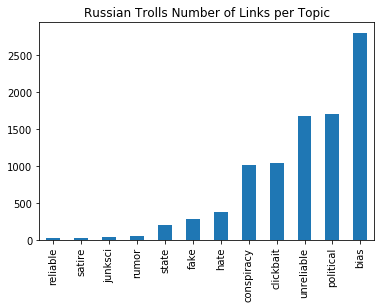

In [102]:
# # we'll filter out the non-represented classes, sort them, and plot it!
breakdown[breakdown != 0].sort_values().plot(
    kind='bar', title='Russian Trolls Number of Links per Topic'
);

We can see the websites and their influence in those fields.

In [116]:
df_questionable[df_questionable['bias'] == 1]['link.domain_resolved'].value_counts(25).head(25)

breitbart.com              0.247050
dailycaller.com            0.111906
truthfeed.com              0.088309
thegatewaypundit.com       0.085449
americanthinker.com        0.046478
libertywritersnews.com     0.039328
freebeacon.com             0.035395
conservativetribune.com    0.021452
frontpagemag.com           0.018591
therealstrategy.com        0.016804
westernjournalism.com      0.015016
newsninja2012.com          0.014659
truepundit.com             0.013586
newsmax.com                0.011441
ijr.com                    0.010726
conservativebyte.com       0.010368
weaselzippers.us           0.009653
lifenews.com               0.008938
pjmedia.com                0.008581
redflagnews.com            0.007866
endingthefed.com           0.007508
dailywire.com              0.006793
bb4sp.com                  0.006078
shareblue.com              0.006078
bipartisanreport.com       0.005720
Name: link.domain_resolved, dtype: float64

In [118]:
df_questionable[df_questionable['political'] == 1]['link.domain_resolved'].value_counts(25).head(25)

breitbart.com             0.405993
dailycaller.com           0.183901
washingtonexaminer.com    0.079906
rawstory.com              0.058754
nationalreview.com        0.027027
observer.com              0.026439
redstate.com              0.026439
conservativereview.com    0.019976
ijr.com                   0.017626
thedailybeast.com         0.017039
thinkprogress.org         0.014101
pjmedia.com               0.014101
theblaze.com              0.013514
theintercept.com          0.013514
counterpunch.org          0.010576
shareblue.com             0.009988
dailykos.com              0.008226
judicialwatch.org         0.008226
proudemocrat.com          0.007051
dennismichaellynch.com    0.007051
fusion.net                0.005875
weeklystandard.com        0.005288
alternet.org              0.005288
mintpressnews.com         0.002350
commondreams.org          0.002350
Name: link.domain_resolved, dtype: float64

In [119]:
df_questionable[df_questionable['unreliable'] == 1]['link.domain_resolved'].value_counts(25).head(25)

breitbart.com              0.412291
thegatewaypundit.com       0.142601
washingtonexaminer.com     0.081146
libertywritersnews.com     0.065632
wikileaks.org              0.050119
conservativetribune.com    0.035800
politicususa.com           0.026253
newsmax.com                0.019093
ijr.com                    0.017900
weaselzippers.us           0.016110
redflagnews.com            0.013126
teaparty.org               0.010143
shareblue.com              0.010143
cnsnews.com                0.008950
thepoliticalinsider.com    0.008353
occupydemocrats.com        0.007757
wnd.com                    0.007757
youngcons.com              0.007757
theantimedia.org           0.005967
madworldnews.com           0.005370
usuncut.com                0.005370
anonews.co                 0.004177
rightwingnews.com          0.003580
guccifer2.wordpress.com    0.002983
breaking911.com            0.002983
Name: link.domain_resolved, dtype: float64

In [120]:
df_questionable[df_questionable['clickbait'] == 1]['link.domain_resolved'].value_counts(25).head(25)

dailycaller.com               0.300962
libertywritersnews.com        0.105769
rawstory.com                  0.096154
lifezette.com                 0.054808
redstate.com                  0.043269
politicususa.com              0.042308
westernjournalism.com         0.040385
truepundit.com                0.036538
twitchy.com                   0.031731
lifenews.com                  0.024038
theblaze.com                  0.022115
yournewswire.com              0.017308
bipartisanreport.com          0.015385
therightscoop.com             0.014423
dailykos.com                  0.013462
wnd.com                       0.012500
occupydemocrats.com           0.012500
americanlookout.com           0.010577
ilovemyfreedom.org            0.009615
usuncut.com                   0.008654
madworldnews.com              0.008654
redstatewatcher.com           0.007692
dailynewsbin.com              0.006731
conservativefiringline.com    0.006731
heatst.com                    0.005769
Name: link.domain_resolve

In [121]:
df_questionable[df_questionable['conspiracy'] == 1]['link.domain_resolved'].value_counts(25).head(25)

truthfeed.com                  0.242871
thegatewaypundit.com           0.235005
infowars.com                   0.126844
conservativetribune.com        0.058997
therealstrategy.com            0.046214
zerohedge.com                  0.044248
rickwells.us                   0.035398
redflagnews.com                0.021632
bb4sp.com                      0.016716
thepoliticalinsider.com        0.013766
freedomoutpost.com             0.012783
angrypatriotmovement.com       0.012783
theantimedia.org               0.009833
thefederalistpapers.org        0.009833
jihadwatch.org                 0.006883
canadafreepress.com            0.006883
conservativefiringline.com     0.006883
govtslaves.info                0.005900
usherald.com                   0.005900
centerforsecuritypolicy.org    0.005900
clashdaily.com                 0.005900
gopthedailydose.com            0.004916
wearechange.org                0.004916
globalresearch.ca              0.004916
dcclothesline.com              0.004916


# Temporal Analysis Of Misinfomation Sites
Were links from these misinfomration hubs shared at stetegic times?

In [74]:
dat1 = (df_questionable[(df_questionable['domain'].isnull()) 
                      & (df_questionable['tweet.created_at'] >= datetime.datetime(2016,6,1) )]
 ['tweet.created_at'].dt.date.value_counts()
).reset_index()

dat2 = (df_questionable[ (~df_questionable['domain'].isnull()) 
                       & (df_questionable['tweet.created_at'] >= datetime.datetime(2016,6,1) )]
 ['tweet.created_at'].dt.date.value_counts()).reset_index()

dat1.sort_values(by='index', inplace=True)
dat2.sort_values(by='index', inplace=True)

merge = dat1.merge(dat2, on='index', how='outer')

def ratio(row):
    return row['tweet.created_at_y'] / row['tweet.created_at_x'] 

merge['ratio'] = merge.apply(ratio, axis=1)

In [75]:
merge['index'] = pd.to_datetime(merge['index'])
merge_ = merge[(~merge['ratio'].isnull()) & 
               (merge['index'] >= datetime.datetime(2016,7,17))]

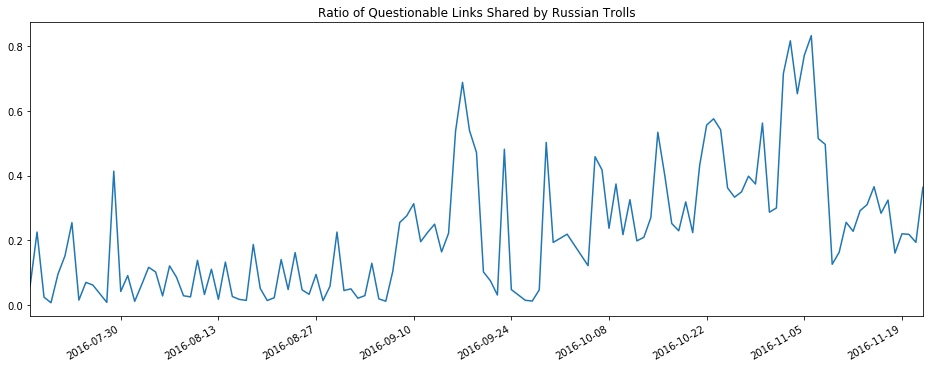

In [76]:
ax = merge_.plot(x='index', y='ratio', legend=False, 
                 title='Ratio of Questionable Links Shared by Russian Trolls',
                 figsize=(16,6))
ax.xaxis.label.set_visible(False)
fig = ax.get_figure();

This plot may not be as infomrative as we like, as the data collection methods were not disclosed. For that reason we shouldn't assume any full-ness amongst the Tweets we have.

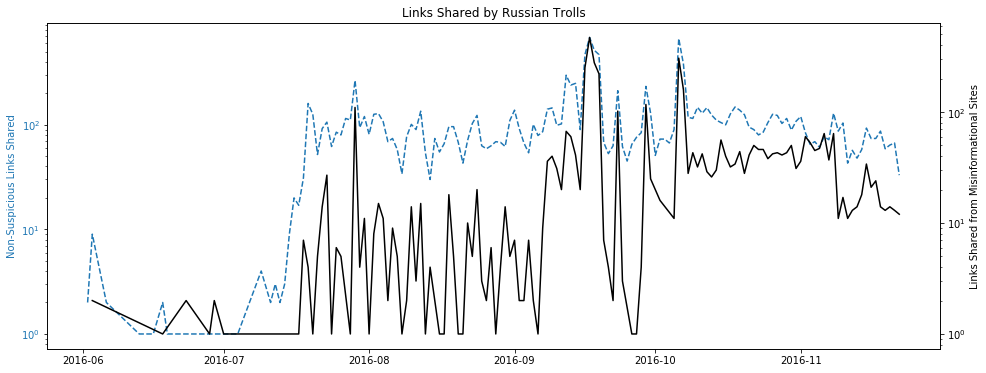

In [109]:
x1, y1 = dat1['index'], dat1['tweet.created_at']
x2, y2 = dat2['index'], dat2['tweet.created_at']

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(111)
ax1.plot(x1, y1, '--')
ax1.set_ylabel('Non-Suspicious Links Shared', color='C0')

ax2 = ax1.twinx()
ax2.plot(x2, y2, color='k')
ax2.set_ylabel('Links Shared from Misinformational Sites')
for tl in ax1.get_yticklabels():
    tl.set_color('C0')
ax1.set_yscale('log')
ax2.set_yscale('log')

plt.title("Links Shared by Russian Trolls");

Here we can try to identify spikes in sharing of misinformation (black).<br>
We see spikes in late July (2016-07-29), Mid-September (2016-09-16 to 18), and early-October (2016-10-06 to 07).

In [130]:
dat2.sort_values(by='tweet.created_at', ascending=False).head(10)

,index,tweet.created_at
0,2016-09-17,470
1,2016-10-06,306
2,2016-09-18,278
3,2016-09-16,251
4,2016-09-19,221
5,2016-10-07,159
6,2016-09-29,117
7,2016-07-29,110
8,2016-09-23,102
9,2016-09-12,67


We can calculate the correlation between the seemingly innoculous links and mininformation links using the Spearman coefficient.

In [108]:
spearmanr(merge_['tweet.created_at_x'], 
          merge_['tweet.created_at_y'])

SpearmanrResult(correlation=0.5935672824488576, pvalue=3.724636041569835e-13)

## Clustering Users and Dimensionality Reduction
We can use types of misinformation favored by each Troll account to cluster similar users.<br>
For each user we will calculate the proportion of each type of misinformation shared, and reduce the values from the the classes of misinformation into two dimensions for visualization.

In [73]:
def normalize(row):
    return row / row.sum()

Here we will aggregate our link data by user, and count the number of links shared for each class of misinformation (`media_classes`), then `normalize` these values between 0-1.

In [103]:
one_hot_domains_questionable = df_questionable.groupby('user.id')[media_classes].sum().fillna(0)
one_hot_domains_questionable = one_hot_domains_questionable.apply(normalize, axis=1).fillna(0)

We use T-SNE for dimensionality reduction. Although we should be weary that we have a tiny dataset, this can still give us a good ball-park for user similarity.

In [104]:
tsne = TSNE(n_components=2, learning_rate=150, verbose=2).fit_transform(one_hot_domains_questionable)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 334 samples in 0.000s...
[t-SNE] Computed neighbors for 334 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 334 / 334
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.024s
[t-SNE] Iteration 50: error = 51.9312897, gradient norm = 0.5711685 (50 iterations in 0.431s)
[t-SNE] Iteration 100: error = 49.8780174, gradient norm = 0.5977964 (50 iterations in 0.447s)
[t-SNE] Iteration 150: error = 50.6728859, gradient norm = 0.5891107 (50 iterations in 0.416s)
[t-SNE] Iteration 200: error = 50.9719925, gradient norm = 0.5903067 (50 iterations in 0.447s)
[t-SNE] Iteration 250: error = 50.3423920, gradient norm = 0.5731412 (50 iterations in 0.428s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.342392
[t-SNE] Iteration 300: error = 0.3383198, gradient norm = 0.0026085 (50 iterations in 0.385s)
[t-SNE] Iteration 350: error = 0.3191045, gradient norm = 0.0003634 (

We can then normalize these reduced values, and plot them as a scatterplot.

In [105]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

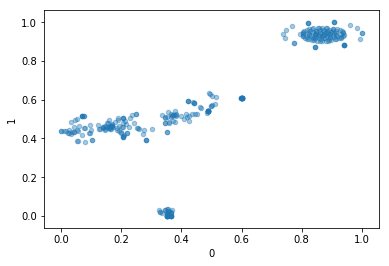

In [107]:
pd.DataFrame(list(zip(tx,ty))).plot.scatter(
    x=0, y=1, alpha=.4);

## Local News
In addition to using categories of misinformation as features, we can also label domains as local news using the USNPL dataset, which has been <a href="https://nbviewer.jupyter.org/github/yinleon/usnpl/blob/master/scrape_usnpl.ipynb">scraped and documented</a>.

In [79]:
usnpl_clean_url = 'https://raw.githubusercontent.com/yinleon/usnpl/master/data/usnpl_newspapers_twitter_ids.csv'
df_usnpl = pd.read_csv(usnpl_clean_url)
len(df_usnpl)

6221

In [80]:
df_usnpl['Website'] = df_usnpl['Website'].apply(remove_www)
df_usnpl_one_hot = pd.get_dummies(df_usnpl[['Website', 'Medium']], columns=['Medium'])

In [81]:
remap = {
    'Website' : 'domain',
    'Medium' : 'state_level_media',
    'Geography' : 'state'
}

remap_vals = {
    'Newspapers' : 'newspaper',
    'College Newspapers' : 'college_newspaper',
    'Magazines' : 'magazine'
}

In [82]:
df_usnpl.columns = [remap.get(c,c) for c in df_usnpl.columns]

In [83]:
df_usnpl['state_level_media'] = df_usnpl['state_level_media'].replace(remap_vals)

In [84]:
df_usnpl_one_hot = pd.get_dummies(df_usnpl[['domain', 'state_level_media']], columns=['state_level_media'])

In [85]:
df_questionable_2 = pd.merge(left= df_questionable, left_on= 'link.domain_resolved', 
                             right= df_usnpl_one_hot, right_on= 'domain', how= 'left')

In [86]:
df_questionable_2.head(3)

,link.domain,link.url_long,tweet.created_at,tweet.id,tweet.text,user.id,link.domain_resolved,link.url_long_resolved,domain_x,bias,...,reliable,rumor,satire,state,unreliable,notes,domain_y,state_level_media_college_newspaper,state_level_media_magazine,state_level_media_newspaper
0,ln.is,http://ln.is/twitchy.com/loriz-31/3yafU,2016-09-18 19:46:25,777594647875059712,RT @NahBabyNah: Twitchy: Chuck Todd caught out...,1694026190,twitchy.com,http://twitchy.com/loriz-31/3yafU,twitchy.com,0.0,...,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,freedomoutpost.com,http://freedomoutpost.com/2013/02/the-use-of-r...,2016-09-19 13:20:08,777859822679158784,"RT @leonpui_: Hillary Clinton, Obama and the D...",1649967228,freedomoutpost.com,http://freedomoutpost.com/2013/02/the-use-of-r...,freedomoutpost.com,1.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,www.informationliberation.com,http://www.informationliberation.com/?id=55568,2016-09-30 23:29:54,781999544502521857,RT @PrisonPlanet: Hillary's anti-Trump poster ...,2606301939,informationliberation.com,http://www.informationliberation.com/?id=55568,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
cols = df_os.columns.tolist() + df_usnpl_one_hot.columns.tolist()
media_classes = [c for c in cols if c not in ['domain', 'notes']]
breakdown = df_questionable_2[media_classes].sum(axis=0)
breakdown.sort_values(ascending=False)

state_level_media_newspaper            3125.0
bias                                   2797.0
political                              1702.0
unreliable                             1676.0
clickbait                              1040.0
conspiracy                             1017.0
hate                                    382.0
fake                                    281.0
state                                   205.0
rumor                                    50.0
state_level_media_magazine               34.0
junksci                                  33.0
satire                                   24.0
reliable                                 22.0
state_level_media_college_newspaper       1.0
dtype: float64

In [90]:
one_hot_domains_questionable = df_questionable_2.groupby('user.id')[media_classes].sum().fillna(0)
one_hot_domains_questionable = one_hot_domains_questionable.apply(normalize, axis=1).fillna(0)

tsne = TSNE(n_components=2, learning_rate=150, verbose=2).fit_transform(one_hot_domains_questionable)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 334 samples in 0.006s...
[t-SNE] Computed neighbors for 334 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 334 / 334
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.025s
[t-SNE] Iteration 50: error = 51.3555794, gradient norm = 0.5776203 (50 iterations in 0.722s)
[t-SNE] Iteration 100: error = 50.1537361, gradient norm = 0.5854487 (50 iterations in 0.348s)
[t-SNE] Iteration 150: error = 49.4357681, gradient norm = 0.5965114 (50 iterations in 0.321s)
[t-SNE] Iteration 200: error = 49.1035690, gradient norm = 0.5555739 (50 iterations in 0.372s)
[t-SNE] Iteration 250: error = 48.9232483, gradient norm = 0.5693035 (50 iterations in 0.344s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.923248
[t-SNE] Iteration 300: error = 0.3240951, gradient norm = 0.0018050 (50 iterations in 0.312s)
[t-SNE] Iteration 350: error = 0.3106754, gradient norm = 0.0004510 (

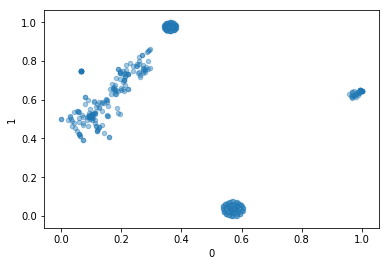

In [93]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

pd.DataFrame(list(zip(tx,ty))).plot.scatter(
    x=0, y=1, alpha = .4);

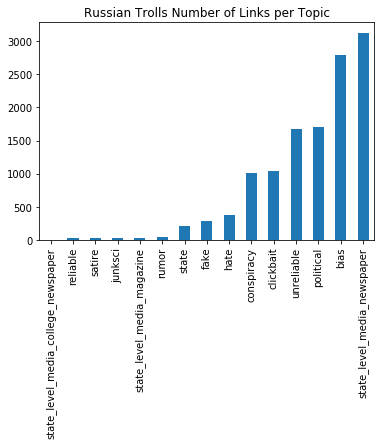

In [462]:
# correct joining
breakdown[breakdown != 0].sort_values().plot(
    kind='bar', title='Russian Trolls Number of Links per Topic'
);

## State level news outlets
We can use the USNPL dataset's grainularity to label domains on a state-level.

In [94]:
df_usnpl_one_hot_state = pd.get_dummies(df_usnpl[['domain', 'state_level_media', 'state']], columns=['state'])

In [95]:
df_questionable_3 = pd.merge(left= df_questionable, left_on= 'link.domain_resolved', 
                             right= df_usnpl_one_hot_state, right_on= 'domain', how= 'left')

In [96]:
cols = df_os.columns.tolist() + df_usnpl_one_hot_state.columns.tolist()
# these are the columns we'll base out calculations on.
media_classes = [c for c in cols if c not in ['domain', 'notes']]
breakdown = df_questionable_3[media_classes].sum(axis=0)
breakdown.sort_values(ascending=False).head(20)

bias          2797.0
political     1702.0
unreliable    1676.0
state_DC      1413.0
clickbait     1040.0
conspiracy    1017.0
state_NY       620.0
hate           382.0
fake           281.0
state          205.0
state_NJ       189.0
state_VA       154.0
state_TX       145.0
state_AZ       139.0
state_CA       117.0
state_IL        67.0
state_MO        66.0
state_MI        59.0
rumor           50.0
state_PA        44.0
dtype: float64

In [450]:
one_hot_domains_questionable = df_questionable_3.groupby('user.id')[media_classes].sum().fillna(0)
one_hot_domains_questionable = one_hot_domains_questionable.apply(normalize, axis=1).fillna(0)

tsne = TSNE(n_components=2, learning_rate=150, verbose=2).fit_transform(one_hot_domains_questionable)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 343 samples in 0.001s...
[t-SNE] Computed neighbors for 343 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 343 / 343
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.023s
[t-SNE] Iteration 50: error = 53.8615456, gradient norm = 0.5651188 (50 iterations in 0.472s)
[t-SNE] Iteration 100: error = 53.9107666, gradient norm = 0.5786546 (50 iterations in 0.435s)
[t-SNE] Iteration 150: error = 56.0051346, gradient norm = 0.5726314 (50 iterations in 0.483s)
[t-SNE] Iteration 200: error = 54.3675957, gradient norm = 0.5751335 (50 iterations in 0.480s)
[t-SNE] Iteration 250: error = 54.7553596, gradient norm = 0.5620599 (50 iterations in 0.438s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.755360
[t-SNE] Iteration 300: error = 0.3978505, gradient norm = 0.0024864 (50 iterations in 0.382s)
[t-SNE] Iteration 350: error = 0.3884825, gradient norm = 0.0004062 (

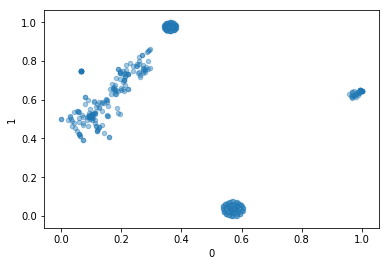

In [97]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

pd.DataFrame(list(zip(tx,ty))).plot.scatter(
    x=0, y=1, alpha = .4)

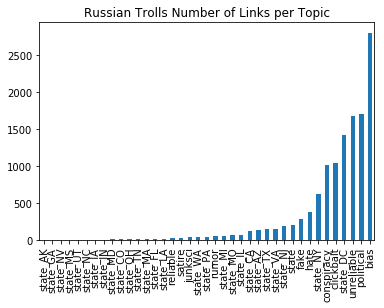

In [99]:
# correct joining
breakdown[breakdown != 0].sort_values().plot(
    kind='bar', title='Russian Trolls Number of Links per Topic'
);

Looking at the DC, CA and NY news outlets suggests some flaws in USNPL.<br>
These outlets, although located in the state are not state-level news!

In [132]:
df_questionable_3[df_questionable_3['state_DC'] == 1]['link.domain_resolved'].value_counts(25)

washingtonpost.com        0.443737
thehill.com               0.215145
politico.com              0.151451
washingtonexaminer.com    0.096249
washingtontimes.com       0.048125
townhall.com              0.045294
Name: link.domain_resolved, dtype: float64

In [146]:
df_questionable_3[df_questionable_3['state_NY'] == 1]['link.domain_resolved'].value_counts()

nytimes.com        233
nypost.com         130
nydailynews.com    124
wsj.com             57
observer.com        45
newyorker.com       15
nymag.com           14
silive.com           1
amny.com             1
Name: link.domain_resolved, dtype: int64

In [138]:
df_questionable_3[df_questionable_3['state_CA'] == 1]['link.domain_resolved'].value_counts()

investors.com               52
latimes.com                 23
mercurynews.com             20
dailynews.com                9
hollywoodreporter.com        4
blackvoicenews.com           3
sfchronicle.com              2
variety.com                  2
smobserved.com               1
sandiegouniontribune.com     1
Name: link.domain_resolved, dtype: int64

The other states appear to be more on-par with local news.

In [145]:
df_questionable_3[df_questionable_3['state_NJ'] == 1]['link.domain_resolved'].value_counts()

nj.com    189
Name: link.domain_resolved, dtype: int64

In [139]:
df_questionable_3[df_questionable_3['state_AZ'] == 1]['link.domain_resolved'].value_counts()

azcentral.com    139
Name: link.domain_resolved, dtype: int64

In [140]:
df_questionable_3[df_questionable_3['state_TX'] == 1]['link.domain_resolved'].value_counts()

mysanantonio.com     75
chron.com            62
star-telegram.com     4
texastribune.org      2
orangeleader.com      1
dallasnews.com        1
Name: link.domain_resolved, dtype: int64

In [141]:
df_questionable_3[df_questionable_3['state_IL'] == 1]['link.domain_resolved'].value_counts()

chicagotribune.com      51
chicagodefender.com      9
chicago.suntimes.com     6
depauliaonline.com       1
Name: link.domain_resolved, dtype: int64

In [142]:
df_questionable_3[df_questionable_3['state_MO'] == 1]['link.domain_resolved'].value_counts()

stltoday.com    66
Name: link.domain_resolved, dtype: int64

In [143]:
df_questionable_3[df_questionable_3['state_MI'] == 1]['link.domain_resolved'].value_counts()

detroitnews.com    55
freep.com           4
Name: link.domain_resolved, dtype: int64

In [144]:
df_questionable_3[df_questionable_3['state_PA'] == 1]['link.domain_resolved'].value_counts()

post-gazette.com                  35
triblive.com                       7
timesonline.com                    1
newpittsburghcourieronline.com     1
Name: link.domain_resolved, dtype: int64